In [1]:
from typing import List, Optional
from autograd import grad, jacobian, elementwise_grad
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from tqdm import tqdm
import math
import scipy 
from scipy import linalg
from numpy import linalg as LA

sys.path.insert(0, os.path.join(".."))
%reload_ext autoreload
%autoreload 2

In [2]:
from lib import problems as pr
from lib import optimisers as opt
from lib import utils as ut

In [3]:
plt.rcParams['figure.figsize'] = 15, 8
# plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 18

# Implementation

Original problem:
$$\min_x p(x) + q(x) \rightarrow \min_x p(x) + \max_y <y, Ax> - g(y) = \min_x \max_y \underbrace{p(x)}_{f(x)} + <y, Ax> - g(y)$$
Functional for inner subproblem:

\begin{gather}
A_{\theta}(x) = f(x^k_g) + <\nabla f(x^k_g), x - x^k_g> + \frac{1}{2\theta}||x - x^k_g||_2^2 + q(x) \\
\min_x A_{\theta}(x) = \min_x \underbrace{\frac{1}{2\theta}||x||_2^2 + <\nabla f(x^k_g) - \frac{1}{\theta}x^k_g, x>}_{f(x)} + \max_y <y, Ax> - g(y)
\end{gather}

In [128]:
import numpy as np
from autograd import grad
from typing import Optional, Union, Callable
from lib.base_opt import BaseSaddleOpt
from lib.problems import BaseSaddle



class AccEG(BaseSaddleOpt):
    def __init__(self,
                 problem: BaseSaddle,
                 inner_optimiser: BaseSaddleOpt,
                 inner_max_iter: int,
                 x0: np.ndarray, 
                 y0: np.ndarray,
                 eps: float,
                 stopping_criteria: Optional[str],
                 params: dict
                ):
        super().__init__(problem, x0, y0, eps, stopping_criteria, params)
        if params is None:
            self.params = self._get_acceg_params(problem)
        self.x_f = x0.copy()
        self.inner_opt = inner_optimiser
        self.inner_max_iter = inner_max_iter
        
 
    @staticmethod
    def _get_acceg_params(problem: BaseSaddle):
        _mu = min(problem.mu_x, problem.mu_y)
        L_p = problem.L_x
        tau = min(1, _mu**.5/(2*L_p**.5))
        theta = 0.5/L_p
        eta = min(0.5/_mu, 0.5/(_mu*L_p)**.5)
        alpha = _mu
        return {"tau": tau,
                "theta": theta,
                "eta": eta,
                "alpha": alpha
               }
    
    
    def step(self):
        x_g = self.params["tau"]*self.x + (1 - self.params["tau"])*self.x_f
        
        subproblem = BaseSaddle(A=self.problem.A)
        # min max f(x) + <y, Ax> - g(y)
        
        grad_p, _ = self.problem.fg_grads(x_g, self.y)
        subproblem.f = lambda x: 0.5/self.params["theta"]*x@x + (grad_p - 1/self.params["theta"]*x_g)@x
        subproblem.mu_x = subproblem.L_x = self.params["theta"]**-1
        subproblem._optimiser_params = self.params
        subproblem._optimiser_params["right_part"] = 1/self.params["theta"]*x_g + grad_p
        subproblem.g = self.problem.g
        subproblem.C = self.problem.C 
        subproblem.mu_y = self.problem.mu_y
        subproblem.L_y = self.problem.L_y
        subproblem.mu_xy = self.problem.mu_xy 
        subproblem.mu_yx = self.problem.mu_yx 
        subproblem.L_xy = self.problem.L_xy
        subproblem.xopt, subproblem.yopt = self.problem.xopt,self.problem.yopt
        subproblem.primal_func = self.problem.primal_func
        subproblem.dual_func = lambda y, x: subproblem.F(-self.params["theta"]*(grad_p - 1/self.params["theta"]*x_g + subproblem.A.T@y), y)
        subproblem.prox_f = lambda v, scale: (v + 1/self.params["theta"]*x_g - grad_p)*self.params["theta"]/(1 + self.params["theta"])
        subproblem.prox_g = self.problem.prox_g
        subproblem.grad_f = grad(subproblem.f)
        subproblem.grad_g = grad(subproblem.g)
        
        inner_optimiser = self.inner_opt(problem=subproblem, x0=x_g,
                                         y0=self.y, eps=self.eps,
                                         stopping_criteria='sliding',
                                         params=None
                                        )
        
        _loss, _, _ = inner_optimiser(max_iter=self.inner_max_iter,
                                         verbose=0)
        # plt.plot(_loss)
        # plt.show()
        # print(inner_optimiser.iter_count)
        self.x_f = inner_optimiser.x
        self.y = inner_optimiser.y
        
        # TODO: take grad without y
        gx, _ = self.problem.fg_grads(self.x_f, inner_optimiser.y)
        _A = self.problem.A
        _C = self.problem.C
        gx += 3/4*_A.T @ LA.inv(_C) @ _A @ self.x_f
        self.x = (self.x + 
                  self.params['eta']*self.params['alpha']*(self.x_f - self.x) - 
                  self.params['eta']*gx
                 ) 

In [129]:
nx = ny = 5
problem_n = pr.BilinearQuadraticSaddle.with_parameters(nx=nx, ny=ny, L_x=10, mu_x=1, L_y=10, mu_y=1, L_xy=13.99959999, mu_xy=2)

In [130]:
import lib.cls_optimisers as copt
inner_optimiser = copt.APDG

In [131]:
x0 = np.random.randn(nx, )
y0 = np.random.randn(ny, )

optimiser = AccEG(problem_n,
                  inner_optimiser=inner_optimiser,
                  inner_max_iter=1000,
                  x0=x0, 
                  y0=y0,
                  eps=1e-5,
                  stopping_criteria="loss",
                  params=None
                 )

In [132]:
loss, x, y = optimiser(max_iter=1000,
                       verbose=1)

AccEG:   5%|███▍                                                                     | 47/1000 [00:01<00:27, 34.83it/s]


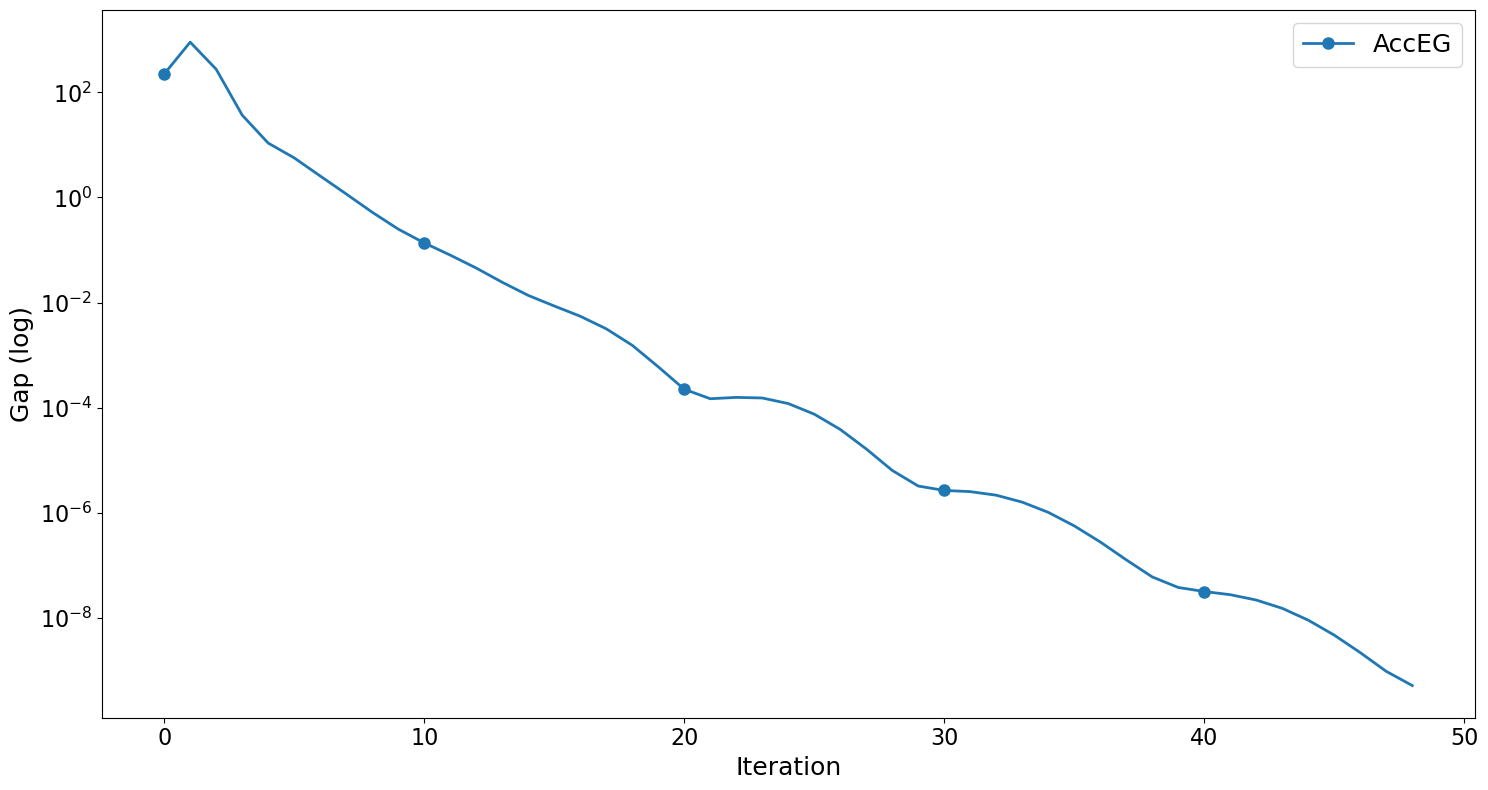

In [133]:
%matplotlib inline
plot_interval = 1
markevery=10
_gap = optimiser.all_metrics["gap"]
plt.semilogy(np.arange(0, len(_gap)+plot_interval-1, plot_interval),
             _gap[::plot_interval],
             "o-",
             markevery=markevery,
             label="AccEG"
            )
# plt.xscale('log')
plt.xlabel("Iteration")
plt.ylabel("Gap (log)")
plt.legend()
plt.tight_layout()

In [63]:
class FOAM(BaseSaddleOpt):
    """
    FOAM algorithm from https://arxiv.org/pdf/2205.05653.pdf 
    """
    def __init__(self,
                 problem: BaseSaddle,
                 x0: np.ndarray, 
                 y0: np.ndarray,
                 eps: float,
                 stopping_criteria: Optional[str],
                 params: dict
                ):
        super().__init__(problem, x0, y0, eps, stopping_criteria, params)
        self.x_f, self.y_f = x0.copy(), y0.copy()
        self.z_f = x0.copy()
        self.z = x0.copy()
        # self.y_prev = y0.copy() 
        self.A = problem.A
        if params is None:
            self.params = self._get_foam_params(problem)
        
        
    @staticmethod
    def _get_foam_params(problem: BaseSaddle):
        """
        Setting the optimal params from pp.8-10
        """
        L_x, L_y, mu_x, mu_y = problem.L_x, problem.L_y, problem.mu_x, problem.mu_y
        L_xy, mu_xy, mu_yx = problem.L_xy, problem.mu_xy, problem.mu_yx
        L = max(L_x, L_y, L_xy)
    
        theta = 8/mu_x
        eta_z = 0.5/mu_x
        gamma_x = 8/mu_x
        gamma_y = theta
        M = 2*max(gamma_x*L, gamma_y*(L + theta**-1))
        alpha = min(1, (theta*mu_y)**.5)
        
        eta_y = min(1/(2*mu_y), theta/(2*alpha))
        _lambda = 1/(5**.5 * M)

        opt_params = {
                      "theta": theta,
                      "gamma_x": gamma_x,
                      "gamma_y": gamma_y,
                      "eta_z": eta_z,
                      "eta_y": eta_y,
                      "alpha": alpha,
                      "lambda": _lambda
                     }
        return opt_params
        
    def a_x(self, x, y, z_g):
        g_x, _ = self.problem.grad(x, y)
        return g_x - 0.5*self.problem.mu_x*x - 0.5*z_g
    
    def a_y(self, x, y, y_g):
        _, g_y = self.problem.grad(x, y)
        return -g_y - 1/self.params["theta"] * (y - y_g)
    
    def beta(self, t):
        return 2/(t + 3)
        
    def step(self):
        _alpha = self.params['alpha']
        _theta = self.params["theta"] 
        _eta_z = self.params["eta_z"] 
        _eta_y = self.params["eta_y"] 
        _gamma_x = self.params["gamma_x"] 
        _gamma_y = self.params["gamma_y"]
        _lambda = self.params["lambda"]
        
        z_g = _alpha * self.z + (1 - _alpha) * self.z_f
        y_g = _alpha * self.y + (1 - _alpha) * self.y_f
        
        _x_m1, _y_m1 = -self.problem.mu_x**-1 * z_g, y_g
        
        x_k_0 = self.problem.prox_f(_x_m1 - _gamma_x*_lambda*self.a_x(_x_m1, _y_m1, z_g),
                                    scale=_gamma_x*_lambda)
        y_k_0 = self.problem.prox_g(_y_m1 - _gamma_y*_lambda*self.a_y(_x_m1, _y_m1, y_g),
                                    scale=_gamma_y*_lambda)
        x_k = x_k_0.copy()
        y_k = y_k_0.copy()
        b_x_k = (_gamma_x*_lambda)**-1 * (_x_m1 - _gamma_x*_lambda*self.a_x(_x_m1, _y_m1, z_g) - x_k_0)
        b_y_k = (_gamma_y*_lambda)**-1 * (_y_m1 - _gamma_y*_lambda*self.a_y(_x_m1, _y_m1, y_g) - y_k_0)
        
        t = 0
        while (_gamma_x*LA.norm(self.a_x(x_k, y_k, z_g) + b_x_k)**2 + 
               _gamma_y*LA.norm(self.a_y(x_k, y_k, y_g) + b_y_k)**2) > (
            1/_gamma_x*LA.norm(x_k - _x_m1)**2 + 
            1/_gamma_y*LA.norm(y_k - _y_m1)**2
        
        ):
            x_k_half = x_k + self.beta(t)*(x_k_0 - x_k) - _gamma_x*_lambda*(self.a_x(x_k, y_k, z_g) + b_x_k)  
            y_k_half = y_k + self.beta(t)*(y_k_0 - y_k) - _gamma_y*_lambda*(self.a_y(x_k, y_k, y_g) + b_y_k)  
            x_k_next = self.problem.prox_f(x_k + self.beta(t)*(x_k_0 - x_k) -
                                           _gamma_x*_lambda*self.a_x(x_k_half, y_k_half, z_g),
                                           scale=_gamma_x*_lambda
                                          )
            y_k_next = self.problem.prox_g(y_k + self.beta(t)*(y_k_0 - y_k) -
                                           _gamma_y*_lambda*self.a_y(x_k_half, y_k_half, y_g),
                                           scale=_gamma_y*_lambda
                                          )
            b_x_k = (_gamma_x*_lambda)**-1 * (x_k + self.beta(t)*(x_k_0 - x_k) -
                                              _gamma_x*_lambda*self.a_x(x_k_half, y_k_half, z_g) - x_k_next)
            b_y_k = (_gamma_y*_lambda)**-1 * (y_k + self.beta(t)*(y_k_0 - y_k) -
                                              _gamma_y*_lambda*self.a_y(x_k_half, y_k_half, y_g) - y_k_next)
            x_k, y_k = x_k_next, y_k_next
            t += 1
        t_k = t    
        
        self.x_f = x_k
        self.y_f = y_k
        
        g_x, g_y = self.problem.grad(self.x_f, self.y_f)
        self.z_f = g_x - self.problem.mu_x*self.x_f + b_x_k
        
        w_f = -g_y - self.problem.mu_y*self.y_f + b_y_k
        self.z = (self.z + _eta_z*self.problem.mu_x**-1 * (self.z_f - self.z) - 
                  _eta_z*(self.x_f + self.problem.mu_x**-1 * self.z_f))
        self.y = (self.y + _eta_y*self.problem.mu_y**-1 * (self.y_f - self.y) - 
                  _eta_y*(w_f + self.problem.mu_y * self.y_f))

        self.x = -self.problem.mu_x**-1 * self.z
        
        self.x = self.proj_x(self.x)
        self.y = self.proj_y(self.y)
        

In [75]:
x0 = np.random.randn(nx, )
y0 = np.random.randn(ny, )

optimiser = FOAM(problem_n,
                 x0=x0, 
                 y0=y0,
                 eps=1e-6,
                 stopping_criteria="loss",
                 params=None
                )

In [76]:
loss, x, y = optimiser(max_iter=100,
                       verbose=1)

FOAM:  21%|███████████████▊                                                           | 21/100 [00:08<00:30,  2.57it/s]


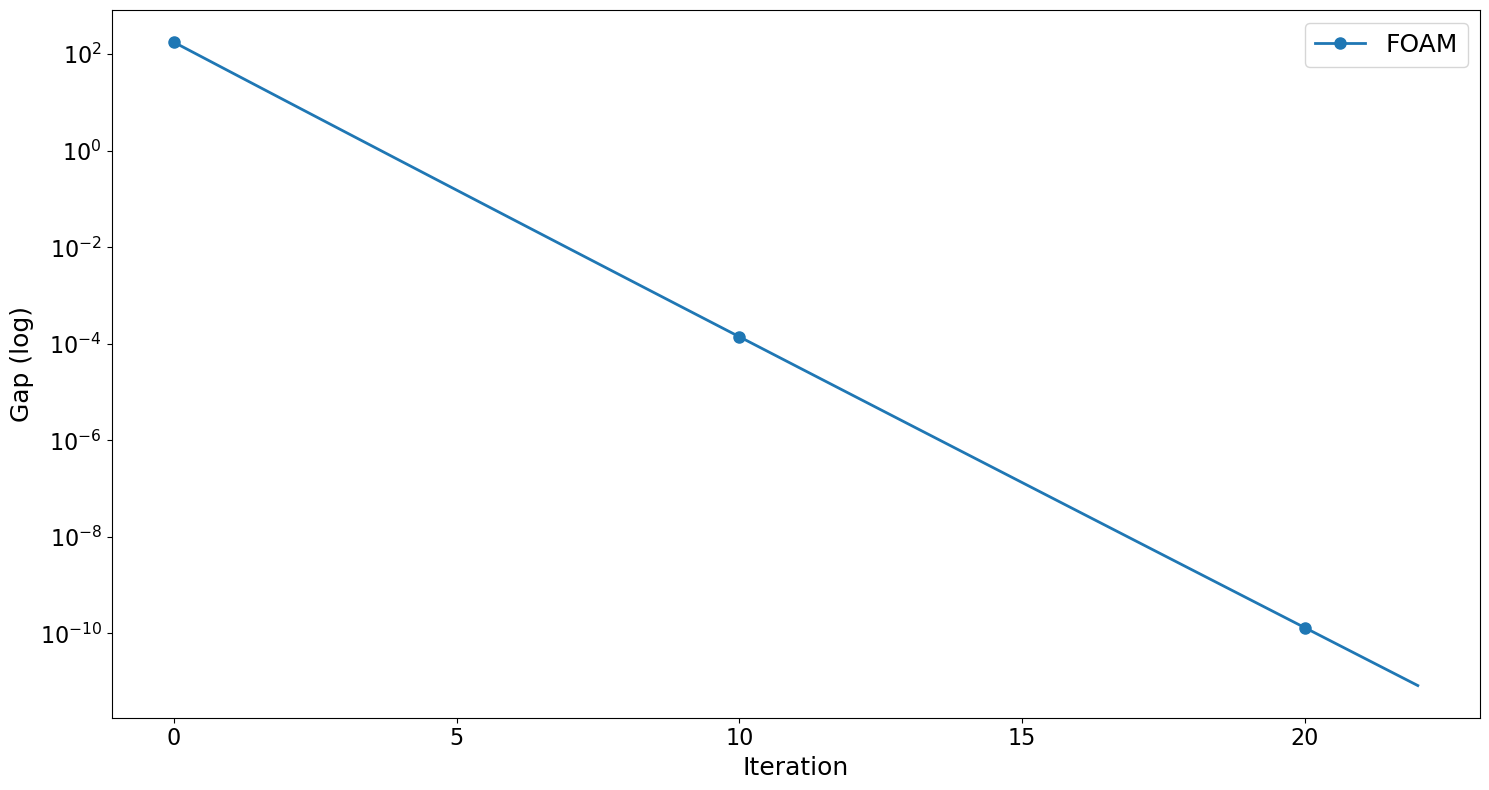

In [77]:
plot_interval = 1
markevery=10
_gap = optimiser.all_metrics["gap"]
plt.semilogy(np.arange(0, len(_gap)+plot_interval-1, plot_interval),
             _gap[::plot_interval],
             "o-",
             markevery=markevery,
             label="FOAM"
            )
# plt.xscale('log')
plt.xlabel("Iteration")
plt.ylabel("Gap (log)")
plt.legend()
plt.tight_layout()

In [123]:
import lib.cls_optimisers as copt
inner_optimiser = copt.FOAM

In [134]:
x0 = np.random.randn(nx, )
y0 = np.random.randn(ny, )
EPS = 1e-5
params = FOAM._get_foam_params(problem_n)
alpha = params["alpha"]
theta = params["theta"]
mu_y = problem_n.mu_y
_inner_iter = int(max(1/alpha, alpha/(theta*mu_y))*np.log(1/EPS))
print(f"Inner iter={_inner_iter}")

optimiser = AccEG(problem_n,
                  inner_optimiser=inner_optimiser,
                  inner_max_iter=_inner_iter,
                  x0=x0, 
                  y0=y0,
                  eps=1e-5,
                  stopping_criteria="loss",
                  params=None
                 )

Inner iter=11


In [135]:
loss, x, y = optimiser(max_iter=50,
                       verbose=1)

AccEG:  94%|██████████████████████████████████████████████████████████████████████▌    | 47/50 [00:01<00:00, 37.73it/s]


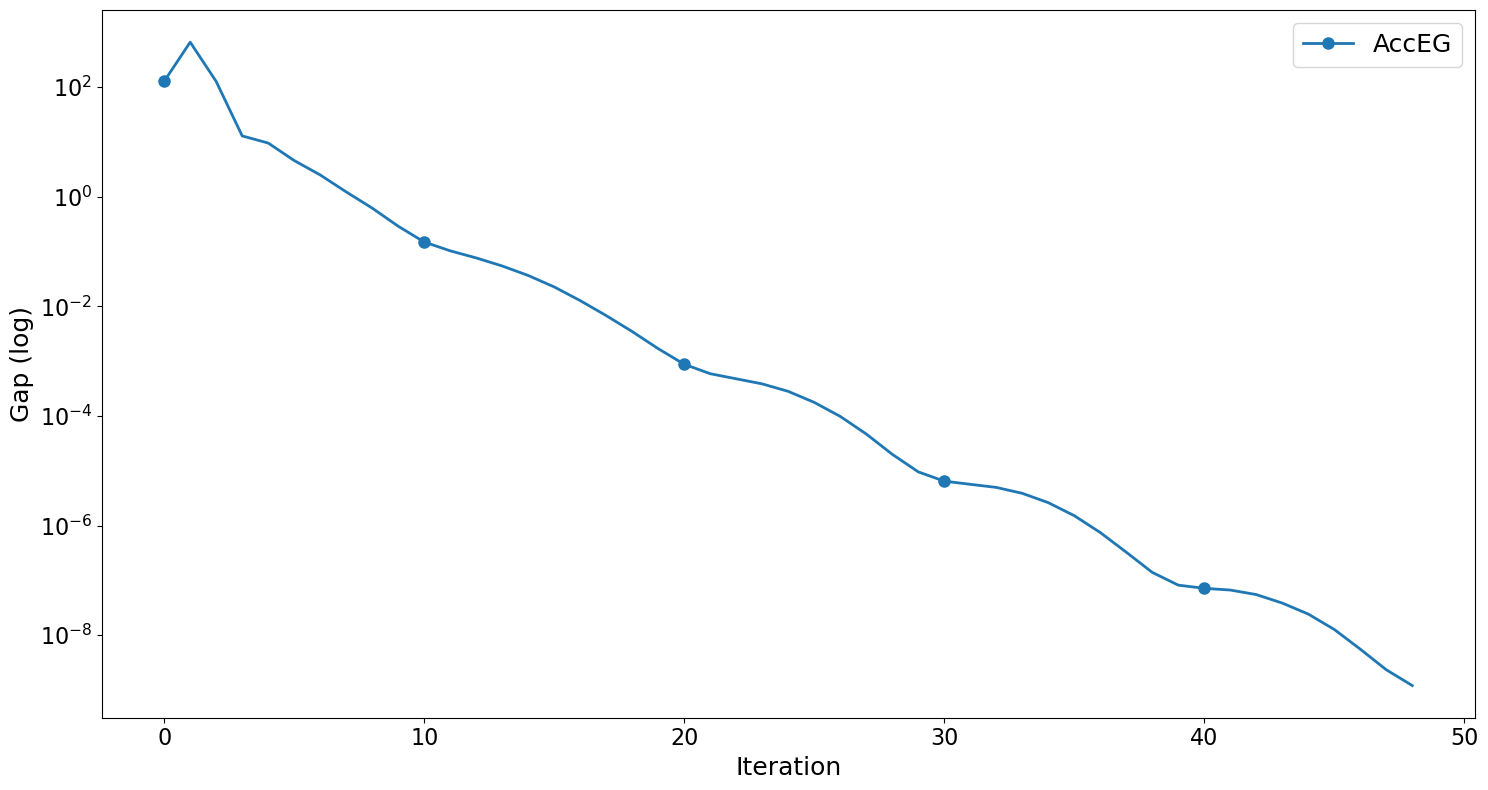

In [136]:
%matplotlib inline
plot_interval = 1
markevery=10
_gap = optimiser.all_metrics["gap"]
plt.semilogy(np.arange(0, len(_gap)+plot_interval-1, plot_interval),
             _gap[::plot_interval],
             "o-",
             markevery=markevery,
             label="AccEG"
            )
# plt.xscale('log')
plt.xlabel("Iteration")
plt.ylabel("Gap (log)")
plt.legend()
plt.tight_layout()

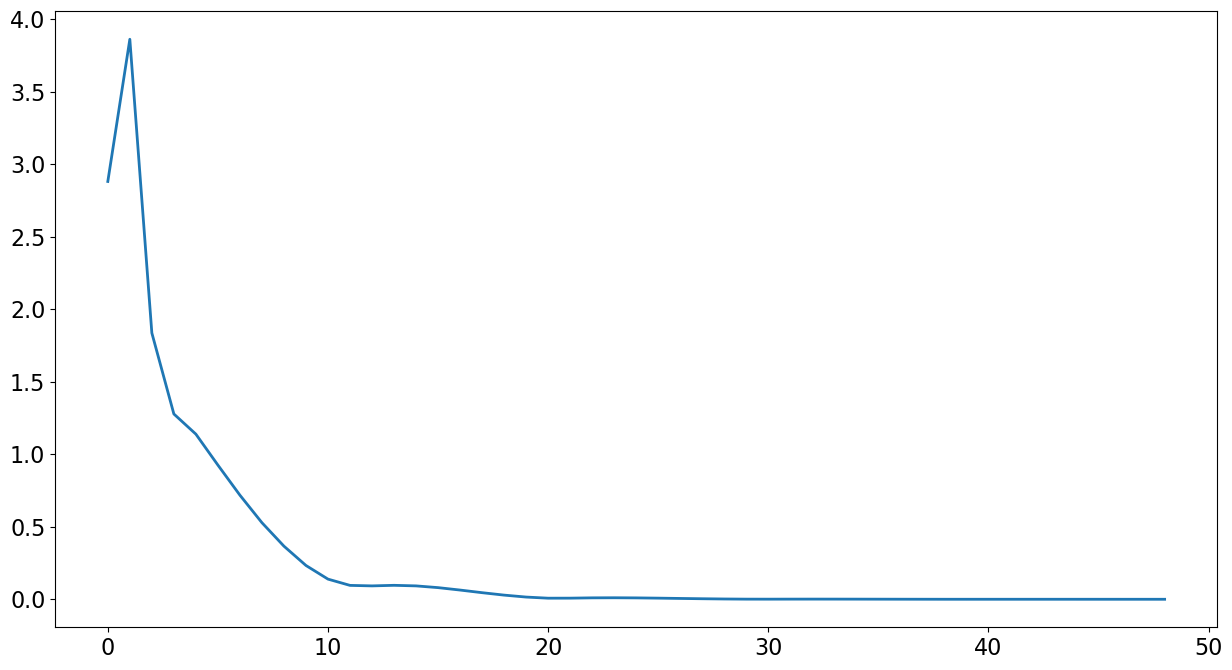

In [137]:
plt.plot(loss)